# Machine Learning-based Force Fields Tutorial

## Introduction

In this tutorial, we demonstrate how we can derive and use machine learning (ML) based force fields for a simple system: *alanine dipeptide in implicit solvent*.

<div>
<img src="https://ambermd.org/tutorials/basic/tutorial0/include/Alanine_Dipeptide_3D.png" width="200"/>
</div>

The following steps will be carried out:
1. Construct the system.
2. Perform biased molecular dynamics simulations using a classical force field ([ff14SBonlysc](https://pubs.acs.org/doi/full/10.1021/ja5032776)) based potential to obtain samples. The bias is provided by [metadynamics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC130499/), which is an adaptive potential of mean force technique.
3. Compute energy and atomic forces of collected configurations using a more expensive semiempirical potential ([PM6](https://link.springer.com/article/10.1007/s00894-007-0233-4)).
4. Fit (learn) the PM6 potential energy surface by Gaussian process regression (GPR) and neural network (NN).
5. Perform molecular dynamics simulations on the ML-based potential energy surface.
6. Compute the free energy surface ([Ramachandran plot](https://en.wikipedia.org/wiki/Ramachandran_plot)) on the ML-based potential.

The entire notebook runs within **20 minutes** tested on a 15-inch, 2017 MacBook Pro (with a 2.9 GHz Quad-Core Intel Core i7 processor).

## Required softwares

For creating the system and initial coordinates we use the [AmberTools](https://ambermd.org/AmberTools.php) package. This package is also used for providing the [ff14SBonlysc](https://pubs.acs.org/doi/full/10.1021/ja5032776) force field and the [PM6](https://link.springer.com/article/10.1007/s00894-007-0233-4) semiempirical potential.

Unbiased and biased molecular dynamics simulations as well as analyses of trajectories are performed within the [Atomic Simulation Environment](https://wiki.fysik.dtu.dk/ase/) (ASE).

Interactive view of the structures and trajectories is provided by [nglview](http://nglviewer.org/nglview/latest/).

Finally, for [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) and construction of the GPR and NN models, we use [PyTorch](https://pytorch.org/). 

## Installation of softwares

We are using [Python3](https://www.python.org/) and [Jupyter notebook](https://jupyter.org/install). The latter, as many other packages that we are using, can be installed by [pip](https://pip.pypa.io/en/stable/), the package installer for Python.

We also need `conda` to install the `ambertools` package.
The simplest way to obtain `conda` is to install [miniconda](https://docs.conda.io/en/latest/miniconda.html). 
If using [Colab](https://colab.research.google.com/), install `condacolab` **from this notebook** by running the following commands:
```
! pip3 install -q condacolab
import condacolab
condacolab.install()
```

Install `ambertools` using `conda` **from this notebook**:
```
! conda install -y -q -c conda-forge ambertools
! echo "source $CONDA_PREFIX/amber.sh > /dev/null" >> ~/.bashrc
```

In order to keep packages consistent with each other, it is advised to install and use `pip` within the `conda` environment:
```
! conda install -y pip
```

Install the following packages **from this notebook** if they are not already available:
```
! pip3 install --quiet tqdm        # progress bar
! pip3 install --quiet numpy       # mathematical functions 
! pip3 install --quiet matplotlib  # plotting
! pip3 install --quiet ase         # atomic / molecular simulation
! pip3 install --quiet nglview     # viewing snapshots and trajectories
! pip3 install "ipywidgets <8"     # for running nglview
! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu  # pytorch
```

## Load packages and functions

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# progress bar
import tqdm

# load ase related functions
from ase import units
from ase.calculators.calculator import Calculator
from ase.calculators.amber import SANDER
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.md import MolecularDynamics
from ase.md import Langevin
from ase.optimize.precon import PreconLBFGS

# load parmed and sander
from parmed.amber.readparm import Rst7, AmberParm
import sander

# load numpy
import numpy as np

# load matplotlib for plotting
import matplotlib.pyplot as plt

# load nglview for visualisation
from nglview import show_file, show_asetraj

# load torch functions for computing derivatives and ML
import torch
import functorch as ft
import torch.autograd.functional as F

# display youtube videos
from IPython.display import YouTubeVideo

### Set the precision to double (64-bit floating point)

In [2]:
dt = torch.float64

## 1. Create the system using AmberTools

#### Create the leap input file for alanine dipeptide (aka dialanine)

In [3]:
%%file leap.in
source leaprc.protein.ff14SBonlysc
dialanine = sequence {ACE ALA NME}
set default PBradii mbondi3 
saveamberparm dialanine dialanine.top dialanine.crd
quit

Overwriting leap.in


#### Run tleap to obtain topology and coordinate files for the specified force field and create a pdb file as well

In [4]:
! tleap -f leap.in > leap.log
! ambpdb -p dialanine.top -c dialanine.crd -aatm > dialanine.pdb

#### Visualize the initial structure

In [5]:
show_file("./dialanine.pdb")

NGLWidget()

## 2. Basic functions within ASE

### 2.1. Load atoms, topology and coordinate files

In [6]:
# read pdb file to Atoms object
atoms = read('dialanine.pdb')

In [7]:
# show the Cartesian coordinates (in Å)
atoms.get_positions()

array([[ 2.   ,  1.   ,  0.   ],
       [ 2.   ,  2.09 ,  0.   ],
       [ 1.486,  2.454,  0.89 ],
       [ 1.486,  2.454, -0.89 ],
       [ 3.427,  2.641,  0.   ],
       [ 4.391,  1.877,  0.   ],
       [ 3.555,  3.97 ,  0.   ],
       [ 2.733,  4.556,  0.   ],
       [ 4.853,  4.614,  0.   ],
       [ 5.408,  4.316,  0.89 ],
       [ 5.661,  4.221, -1.232],
       [ 5.123,  4.521, -2.131],
       [ 6.63 ,  4.719, -1.206],
       [ 5.809,  3.141, -1.241],
       [ 4.713,  6.129,  0.   ],
       [ 3.601,  6.653,  0.   ],
       [ 5.846,  6.835,  0.   ],
       [ 6.737,  6.359,  0.   ],
       [ 5.846,  8.284,  0.   ],
       [ 4.819,  8.648,  0.   ],
       [ 6.36 ,  8.648,  0.89 ],
       [ 6.36 ,  8.648, -0.89 ]])

In [8]:
# get the distance matrix (i.e. distances between all atoms)
atoms.get_all_distances()

array([[0.        , 1.09      , 1.78056508, 1.78056508, 2.17467469,
        2.54676461, 3.3524506 , 3.63076094, 4.60441147, 4.83760478,
        5.02947174, 5.16640407, 6.05989249, 4.5422949 , 5.80232798,
        5.87533914, 6.98848632, 7.15248558, 8.23701232, 8.15099166,
        8.84836731, 8.84836731],
       [1.09      , 0.        , 1.09031738, 1.09031738, 1.52968297,
        2.4004687 , 2.43975921, 2.57263386, 3.80922367, 4.16673013,
        4.41156503, 4.49489166, 5.45921029, 4.14163772, 4.86558219,
        4.83571815, 6.10792444, 6.37679622, 7.29090886, 7.13821581,
        7.92521697, 7.92521697],
       [1.78056508, 1.09031738, 0.        , 1.78      , 2.14349014,
        3.09258048, 2.71498011, 2.60105998, 4.09809578, 4.34155825,
        5.00557669, 5.16010649, 5.99868127, 4.86841442, 4.97104154,
        4.78507325, 6.24458654, 6.60409918, 7.33420752, 7.08989598,
        7.88172012, 8.08021732],
       [1.78056508, 1.09031738, 1.78      , 0.        , 2.14349014,
        3.0925804

In [9]:
# get the atomic masses
atoms.get_masses()

array([ 1.008, 12.011,  1.008,  1.008, 12.011, 15.999, 14.007,  1.008,
       12.011,  1.008, 12.011,  1.008,  1.008,  1.008, 12.011, 15.999,
       14.007,  1.008, 12.011,  1.008,  1.008,  1.008])

In [10]:
# read Amber topology and coordinate files
top = AmberParm('dialanine.top')
crd = Rst7('dialanine.crd')

### 2.2. Setup an ASE calculator

In [11]:
# setup a SANDER calculator using generalized Born implicit solvent 
mm_options = sander.gas_input(5)
calc_ff = SANDER(atoms=atoms, top=top, crd=crd, mm_options=mm_options)
# set the Atoms object calculator
atoms.set_calculator(calc_ff)

### 2.3. Get energy and atomic forces

#### The default unit of energy in ASE is eV that can be converted to kcal / mol by using the corresponding conversion factors

In [12]:
print("Potential energy (kcal/mol): ", atoms.get_potential_energy()*units.mol/units.kcal)

Potential energy (kcal/mol):  -28.284223306903897


In [13]:
print("Forces (kcal/mol/Å): \n", atoms.get_forces()*units.mol/units.kcal)

Forces (kcal/mol/Å): 
 [[ 2.71923793e+00  5.65049159e-01 -5.47658354e-03]
 [ 7.80487423e+00  6.74449490e+00 -5.23573035e-03]
 [-4.40164344e-01 -6.38122542e-01 -8.82356833e-01]
 [-4.18712732e-01 -6.30760638e-01  8.72890658e-01]
 [-1.57154236e+01 -7.20082639e-01  6.08227797e+00]
 [-1.16529859e+01 -1.57236225e+01  9.61427417e+00]
 [-2.71353632e-01 -1.98896086e+01 -1.04589840e+01]
 [-1.40339586e+00 -4.50322908e-01 -1.04985556e-02]
 [ 1.13112650e+01  6.85243653e+00  5.18525726e+00]
 [ 2.95508112e-02  5.14442851e-01  1.34967508e+00]
 [-9.80686440e-01 -4.16621704e+00 -8.88588559e+00]
 [ 5.24517896e-01 -3.72550111e-01 -1.81335607e+00]
 [ 2.48314461e+00 -4.44135141e+00 -3.14395857e+00]
 [ 1.03302869e+01  7.29989917e+00 -8.49798072e+00]
 [ 4.12112008e+00 -1.80059977e+00  6.69333512e+00]
 [-1.09043355e+01  3.91315802e+00 -5.68106385e-01]
 [-5.03558767e+00  9.52160030e+00  4.34611326e+00]
 [-6.04851896e-01 -3.23582310e+00  1.70316059e-01]
 [ 6.09320553e+00  5.05917946e+00 -2.55094472e-02]
 [ 1.867

### 2.4. Perform a geometry optimization

#### We use a the LMFGS method for geometry optimization

In [14]:
opt = PreconLBFGS(atoms, trajectory="geom_opt.traj", use_armijo=True, precon="ID")

opt.run(fmax=0.0001)

PreconLBFGS:   0  14:37:07       -1.226520       0.9745
PreconLBFGS:   1  14:37:07       -1.272629       0.9834
PreconLBFGS:   2  14:37:07       -1.332909       0.7023
PreconLBFGS:   3  14:37:08       -1.375669       0.7742
PreconLBFGS:   4  14:37:08       -1.393535       1.2136
PreconLBFGS:   5  14:37:08       -1.413195       0.7067
PreconLBFGS:   6  14:37:08       -1.433304       0.9102
PreconLBFGS:   7  14:37:08       -1.449865       0.8962
PreconLBFGS:   8  14:37:08       -1.460515       0.6019
PreconLBFGS:   9  14:37:08       -1.471153       0.5923
PreconLBFGS:  10  14:37:08       -1.476936       0.4301
PreconLBFGS:  11  14:37:08       -1.483894       0.4390
PreconLBFGS:  12  14:37:08       -1.488622       0.6044
PreconLBFGS:  13  14:37:08       -1.494424       0.3590
PreconLBFGS:  14  14:37:08       -1.500415       0.4023
PreconLBFGS:  15  14:37:08       -1.507630       0.3770
PreconLBFGS:  16  14:37:08       -1.516111       0.3952
PreconLBFGS:  17  14:37:08       -1.522806      

True

In [15]:
# load trajectory of geometry optimisation
traj = Trajectory('geom_opt.traj')
# show the trajectory
view = show_asetraj(traj)
view.player.parameters = dict(delay=20)
view

NGLWidget(max_frame=123)

## 3. Unbiased molecular dynamics simulation

### 3.1. Create an MD class using the [BAOAB](https://aip.scitation.org/doi/pdf/10.1063/1.4802990) scheme

BAOAB is a numerical integrator for [Langevin dynamics](https://en.wikipedia.org/wiki/Langevin_dynamics) that can model friction by solvent molecules and perturbation caused by occasional high velocity collision:

$$
\begin{cases}
d\mathbf{q} dt = \mathbf{M}^{-1} \mathbf{p} dt \\
d\mathbf{p} dt = -\nabla V(\mathbf{q}) dt - \gamma \mathbf{p}dt + \sqrt{2\gamma \beta^{-1}} \mathbf{M}^{1/2}dW
\end{cases}
$$

where $\mathbf{q}, \mathbf{p} \in \mathbb{R}^{3N}$ are the atomic positions and momenta, $\mathbf{M} \in \mathbb{R}^{3n \times 3N}$ is the diagonal mass matrix, $\gamma > 0$ is the fricition coefficient, $\beta = \frac{1}{k_{\mathrm{B}}T}$ is the inverse temperature with Boltzmann constant $k_{\mathrm{B}}$ and temperature $T$ and $W = W(t)$ is a vector of $3N$ independent Wiener processes.

The above dynamics samples the canonical density: $p(\mathbf{q}, \mathbf{p}) \propto e^{-\beta H(\mathbf{q, p})}$, where $H(\mathbf{q, p})$ is the system Hamiltonian.

The BAOAB scheme is particularly accurate and can efficiently absorb extra heat (produced by some potential of mean force technique like metadynamics).

In [16]:
class BAOAB(MolecularDynamics):
    """Langevin (constant N, V, T) molecular dynamics using the BAOAB scheme.
    Usage: BAOAB(atoms, timestep, T, friction, nscm)
    atoms
        The list of atoms.
    timestep
        The time step.
    T
        The desired temperature, in energy units.
    friction
        A friction coefficient in fs^-1.
    nscm
        Frequency of removing translational and rotational COM motion in number of steps.

    This dynamics accesses the atoms using Cartesian coordinates."""
    def __init__(self, atoms, timestep, T=None, friction=None, *,
                 nscm=0, rndseed=None, trajectory=None, logfile=None, loginterval=1, dtype=torch.float64):
        MolecularDynamics.__init__(self, atoms, timestep, trajectory, logfile, loginterval)
        self.kT = torch.tensor(units.kB * T, dtype=dtype)
        self.frict = torch.tensor(friction / units.fs, dtype=dtype)
        self.nscm = nscm
        if rndseed is not None:
            torch.manual_seed(rndseed)
        self.dtype = dtype
       
        self.halfdt = torch.tensor(0.5 * self.dt, dtype=self.dtype)
        self.m = torch.tensor(atoms.get_masses(), dtype=self.dtype)
        self.sumM = torch.sum(self.m)
        self.M = torch.tensor(atoms.get_masses().repeat(3).reshape(-1, 3), dtype=self.dtype)
        self.invM = 1 / self.M
        self.halfdt_invM = self.halfdt * self.invM
        self.epsilon = torch.exp(-self.dt * self.frict)
        self.chi2_halfM = torch.sqrt(self.kT * (1 - self.epsilon * self.epsilon)) * torch.sqrt(self.M)
        self.f = torch.zeros(atoms.get_positions().shape, dtype=self.dtype)
        
    def step(self, force=None):
        if self.nsteps == 0:
            f = torch.tensor(self.atoms.get_forces(), dtype=self.dtype)
        else:
            f = self.f
        p = torch.tensor(self.atoms.get_momenta(), dtype=self.dtype)
        q = torch.tensor(self.atoms.get_positions(), dtype=self.dtype)
        r = torch.randn(q.shape, dtype=self.dtype)
        
        p = p + self.halfdt * f
        q = q + self.halfdt_invM * p
        p = self.epsilon * p + self.chi2_halfM * r
        q = q + self.halfdt_invM * p
        self.atoms.set_positions(q.detach().numpy())
        f = torch.tensor(self.atoms.get_forces(), dtype=self.dtype)
        p = p + self.halfdt * f
        self.f = f
        self.atoms.set_momenta(p.detach().numpy())
        
        if self.nscm != 0:
            if (self.nsteps+1)%self.nscm == 0 or self.nsteps == 0:
                self.remove_trans_rot()
                
        return f.detach().numpy()
    
    def todict(self):
        return 0
                
    def remove_trans_rot(self):
        # compute COM coordinate
        qcom = torch.tensor(self.atoms.get_center_of_mass(), dtype=self.dtype)
        # compute COM translational momentum, velocity and kinetic energy
        p = torch.tensor(self.atoms.get_momenta(), dtype=self.dtype)
        trans_mom_com = p.sum(axis=0)
        trans_vel_com = trans_mom_com / self.sumM
        trans_kin = 0.5 * torch.dot(trans_vel_com, trans_vel_com) * self.sumM
        # compute COM angular momentum, velocity and kinetic energy
        ang_mom_com = torch.tensor(self.atoms.get_angular_momentum(), dtype=self.dtype)
        rq = torch.tensor(self.atoms.get_positions(), dtype=self.dtype) - qcom
        rq2 = rq**2
        inertia_tensor = torch.zeros((3,3), dtype=self.dtype)
        inertia_tensor[0, 0] = torch.sum(self.m * (rq2[:, 1] + rq2[:, 2]))
        inertia_tensor[1, 1] = torch.sum(self.m * (rq2[:, 0] + rq2[:, 2]))
        inertia_tensor[2, 2] = torch.sum(self.m * (rq2[:, 0] + rq2[:, 1]))
        inertia_tensor[0, 1] = -torch.sum(self.m * (rq[:, 0] * rq[:, 1]))
        inertia_tensor[0, 2] = -torch.sum(self.m * (rq[:, 0] * rq[:, 2]))
        inertia_tensor[1, 2] = -torch.sum(self.m * (rq[:, 1] * rq[:, 2]))
        inertia_tensor[1, 0] = inertia_tensor[0, 1]
        inertia_tensor[2, 0] = inertia_tensor[0, 2]
        inertia_tensor[2, 1] = inertia_tensor[1, 2]
        ang_vel_com = torch.linalg.solve(inertia_tensor, ang_mom_com)
        rot_kin = 0.5 * torch.dot(ang_vel_com, ang_mom_com)

        p = p - self.M * (trans_vel_com + torch.cross(ang_vel_com.repeat(self.atoms.get_number_of_atoms()).reshape(rq.shape), rq))

        self.atoms.set_momenta(p)

### 3.2. Setup an MD simulation

In [17]:
# initialize velocities according to Maxwell-Boltzmann distribution
MaxwellBoltzmannDistribution(atoms=atoms, temperature_K=300)
# setup an unbiased molecular dynamics simulation
dyn_unbiased = BAOAB(atoms=atoms, timestep=0.5*units.fs, T=300, friction=0.05, nscm=1000, rndseed=314159265)

### 3.3. Monitoring the molecular dynamics, collective variables and trajectory

#### Monitoring the MD

In [18]:
class MonitorMD:
    def __init__(self, atoms, dyn):
        self.atoms = atoms
        self.dyn = dyn
        
    def write(self):
        pot = self.atoms.calc.get_property('energy') # potential energy
        kin = self.atoms.get_kinetic_energy()        # kinetic energy
        etot = pot+kin                               # total energy
        temp = kin/(1.5*units.kB)/len(self.atoms)    # temperature in K
        print('step = '+ '%7d' % self.dyn.nsteps + 
            ' |  E_pot = ' + '%6.3f' % (pot * units.mol/units.kcal) +
            ' |  E_kin = ' + '%6.3f' % (kin * units.mol/units.kcal) +
            ' |  E_tot = ' + '%6.3f' % (etot * units.mol/units.kcal) +
            ' |  T = ' + '%5.1f' % temp)
        
monitor_md_unbiased = MonitorMD(atoms, dyn_unbiased)

#### Create internal coordinate classes using `torch.nn.Module`

- Distance: $d_{ij} = \| \mathbf{r}_{ij} \| = \|\mathbf{q}_i - \mathbf{q}_j \|$
- Angle: $\alpha = \cos^{-1} \left( \frac{\mathbf{r}_{ij}^{T} \mathbf{r}_{kj}}{\|\mathbf{r}_{ij}\| \|\mathbf{r}_{kj}\|} \right)$
- Dihedral: $\delta = \tan^{-1} \left( \frac{\left(\frac{\mathbf{r}_{kj}}{\|\mathbf{r}_{kj}\|} \times \left( \mathbf{r}_{ij} - \frac{\mathbf{r}_{ij}^{T}\mathbf{r}_{kj} \cdot \mathbf{r}_{kj}}{\| \mathbf{r}_{kj}\|^{2}} \right) \right)^{T} \left( \mathbf{r}_{lk} - \frac{\mathbf{r}_{lk}^{T}\mathbf{r}_{kj} \cdot \mathbf{r}_{kj}}{\| \mathbf{r}_{kj}\|^{2}} \right)}{\left( \mathbf{r}_{ij} - \frac{\mathbf{r}_{ij}^{T}\mathbf{r}_{kj} \cdot \mathbf{r}_{kj}}{\| \mathbf{r}_{kj}\|^{2}} \right)^{T} \left( \mathbf{r}_{lk} - \frac{\mathbf{r}_{lk}^{T}\mathbf{r}_{kj} \cdot \mathbf{r}_{kj}}{\| \mathbf{r}_{kj}\|^{2}} \right)} \right)$

In [19]:
class Distance(torch.nn.Module):
    def __init__(self, atomi, atomj):
        super(Distance, self).__init__()
        self.atomi = atomi
        self.atomj = atomj
    
    def forward(self, q):
        rij = q[self.atomi, :] - q[self.atomj, :]
        
        return torch.linalg.norm(rij)

class Angle(torch.nn.Module):
    def __init__(self, atomi, atomj, atomk, cos=False):
        super(Angle, self).__init__()
        self.atomi = atomi
        self.atomj = atomj
        self.atomk = atomk
        self.cos = cos
    
    def forward(self, q):
        rij = q[self.atomi, :] - q[self.atomj, :]
        rkj = q[self.atomk, :] - q[self.atomj, :]
                
        if self.cos:
            return torch.dot(rij, rkj) / (torch.linalg.norm(rij) * torch.linalg.norm(rkj))
        else:
            return torch.acos(torch.dot(rij, rkj) / (torch.linalg.norm(rij) * torch.linalg.norm(rkj)))
    
class Dihedral(torch.nn.Module):
    def __init__(self, atomi, atomj, atomk, atoml, tan=False):
        super(Dihedral, self).__init__()
        self.atomi = atomi
        self.atomj = atomj
        self.atomk = atomk
        self.atoml = atoml
        self.tan = tan
    
    def forward(self, q):
        rij = q[self.atomi, :] - q[self.atomj, :]
        rkj = q[self.atomk, :] - q[self.atomj, :]
        rlk = q[self.atoml, :] - q[self.atomk, :]
    
        ekj = rkj / torch.linalg.norm(rkj)
        v = rij - torch.dot(rij, ekj) * ekj
        w = rlk - torch.dot(rlk, ekj) * ekj
        
        if self.tan:
            return torch.dot(torch.cross(ekj, v), w) / torch.dot(v, w)
        else:
            return torch.atan2(torch.dot(torch.cross(ekj, v), w), torch.dot(v, w))

#### Define collective variables (CV) $\varphi$ and $\psi$ for alanine dipeptide

<div>
<img src="https://www.researchgate.net/publication/283336002/figure/fig2/AS:11431281219421856@1706018816554/Dialanine-ps-and-ph-are-the-two-dihedral-angles-that-characterize-the-structure-of-the.jpg" width="400"/>
</div>

In [20]:
# define dihedral phi
phi = Dihedral(5, 7, 9, 15)
# define dihedral psi
psi = Dihedral(7, 9, 15, 17)
# list of CVs
cvs = [phi, psi]

#### Positions as pytorch tensor

In [21]:
q = torch.tensor(atoms.get_positions())
q

tensor([[ 1.8666,  1.2209,  0.5787],
        [ 1.9648,  2.1720,  0.0568],
        [ 1.2469,  2.8852,  0.4601],
        [ 1.7739,  2.0262, -1.0057],
        [ 3.3650,  2.7131,  0.2428],
        [ 4.1864,  2.0824,  0.9088],
        [ 3.6298,  3.8790, -0.3456],
        [ 2.8826,  4.3247, -0.8585],
        [ 4.9133,  4.5882, -0.2863],
        [ 5.4437,  4.2898,  0.6201],
        [ 5.7596,  4.1672, -1.4975],
        [ 5.2592,  4.4584, -2.4224],
        [ 6.7369,  4.6498, -1.4541],
        [ 5.9033,  3.0859, -1.4924],
        [ 4.7333,  6.1227, -0.2293],
        [ 3.6941,  6.6595, -0.6330],
        [ 5.7594,  6.8342,  0.2578],
        [ 6.5800,  6.3250,  0.5591],
        [ 5.7819,  8.2929,  0.3814],
        [ 4.9698,  8.6273,  1.0305],
        [ 6.7319,  8.6187,  0.8098],
        [ 5.6618,  8.7547, -0.6009]], dtype=torch.float64)

#### Value of $\varphi$

In [22]:
phi(q)

tensor(-2.8540, dtype=torch.float64)

#### Gradient of $\varphi$ wrt the positions

In [23]:
grad_phi = ft.jacrev(phi)
grad_phi(q)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1933,  0.1543,  0.3384],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.2149, -0.0758, -0.3741],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.1895, -0.1165, -0.3310],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.2112,  0.0380,  0.3667],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], dtype=torch.float64)

#### Hessian of $\varphi$ wrt the positions

In [24]:
hessian_phi = ft.hessian(phi)
hessian_phi(q).shape

torch.Size([22, 3, 22, 3])

In [25]:
idx = [phi.atomi, phi.atomj, phi.atomk, phi.atoml]
hessian_phi(q)[idx, :, :, :][:, :, idx, :]

tensor([[[[-3.1361e-02, -6.2774e-02,  5.2840e-02],
          [-4.6844e-02,  6.4680e-02,  8.2661e-02],
          [ 7.8206e-02, -1.9062e-03, -1.3550e-01],
          [ 7.1708e-19,  9.8795e-19, -1.7355e-18]],

         [[-6.2774e-02,  1.2025e-01,  1.1156e-01],
          [ 2.0265e-02, -3.7961e-02, -3.5995e-02],
          [ 4.2508e-02, -8.2292e-02, -7.5566e-02],
          [ 2.7769e-17, -8.6694e-18, -7.0804e-20]],

         [[ 5.2840e-02,  1.1156e-01, -8.8891e-02],
          [-4.9079e-02, -8.5593e-03,  8.4805e-02],
          [-3.7605e-03, -1.0300e-01,  4.0859e-03],
          [-5.8754e-19, -1.9155e-18,  3.0042e-18]]],


        [[[-4.6844e-02,  2.0265e-02, -4.9079e-02],
          [ 1.2106e-01,  2.6105e-02, -6.3695e-02],
          [-5.1521e-03,  1.7696e-02,  1.3750e-01],
          [-6.9060e-02, -6.4066e-02, -2.4724e-02]],

         [[ 6.4680e-02, -3.7961e-02, -8.5593e-03],
          [ 2.6105e-02,  2.3868e-02, -9.5902e-02],
          [-3.6995e-02, -9.3300e-03, -1.4936e-02],
          [-5.3789e-0

#### Monitoring the CVs

In [26]:
class MonitorCVs:
    def __init__(self, atoms, cvs):
        self.atoms = atoms
        self.cvs = cvs
        self.values = []
        
    def append(self):
        self.values.append([cv(torch.tensor(self.atoms.get_positions(), dtype=torch.float64)).detach().numpy() for cv in self.cvs])
        
    def get_values(self):
        return np.array(self.values)
        
monitor_cvs_unbiased = MonitorCVs(atoms, cvs)

#### Saving the trajectory

In [27]:
traj_unbiased = Trajectory('md.traj', 'w', atoms=atoms)

#### Attach monitoring objects

In [28]:
dyn_unbiased.attach(monitor_md_unbiased.write, interval=1000)
dyn_unbiased.attach(monitor_cvs_unbiased.append, interval=10)
dyn_unbiased.attach(traj_unbiased.write, interval=1000)

### 3.4. Run the MD

In [29]:
nstep = 100000

dyn_unbiased.run(nstep)

step =       0 |  E_pot = -37.422 |  E_kin = 20.130 |  E_tot = -17.292 |  T = 307.0
step =    1000 |  E_pot = -17.157 |  E_kin = 13.352 |  E_tot = -3.805 |  T = 203.6
step =    2000 |  E_pot = -19.141 |  E_kin = 14.426 |  E_tot = -4.716 |  T = 220.0
step =    3000 |  E_pot = -24.547 |  E_kin = 15.707 |  E_tot = -8.840 |  T = 239.5
step =    4000 |  E_pot = -15.502 |  E_kin = 13.978 |  E_tot = -1.523 |  T = 213.2
step =    5000 |  E_pot = -20.053 |  E_kin = 20.464 |  E_tot =  0.411 |  T = 312.1
step =    6000 |  E_pot = -19.189 |  E_kin = 18.834 |  E_tot = -0.355 |  T = 287.2
step =    7000 |  E_pot = -15.388 |  E_kin = 24.496 |  E_tot =  9.108 |  T = 373.5
step =    8000 |  E_pot = -22.116 |  E_kin = 12.662 |  E_tot = -9.454 |  T = 193.1
step =    9000 |  E_pot = -19.582 |  E_kin = 20.428 |  E_tot =  0.846 |  T = 311.5
step =   10000 |  E_pot = -15.472 |  E_kin = 18.032 |  E_tot =  2.560 |  T = 275.0
step =   11000 |  E_pot = -19.377 |  E_kin = 18.056 |  E_tot = -1.321 |  T = 275.3
ste

True

### 3.5. Visualize

In [30]:
traj = Trajectory('md.traj')
view = show_asetraj(traj)
view.player.parameters = dict(delay=20)
view

NGLWidget(max_frame=100)

''

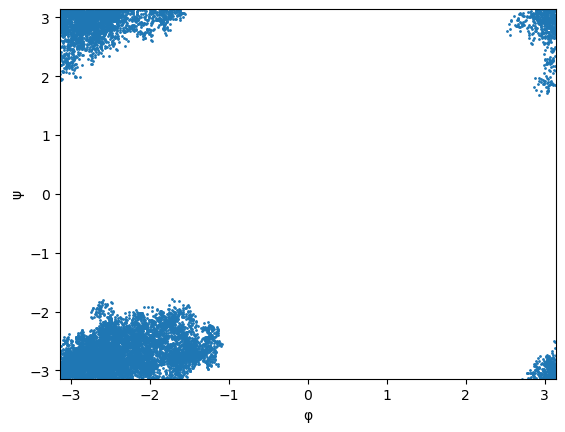

In [31]:
cvs_unibaised = monitor_cvs_unbiased.get_values()

plt.scatter(cvs_unibaised[:, 0], cvs_unibaised[:, 1], s=1)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel('φ')
plt.ylabel('ψ')
;

## 5. Biased molecular dynamics simulation using metadynamics

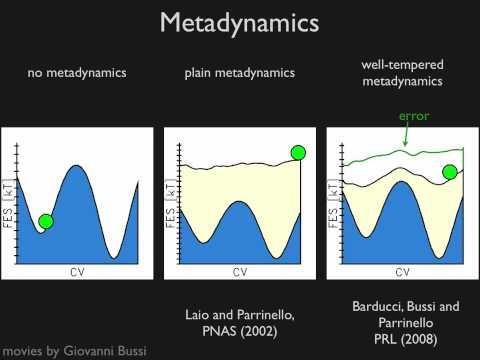

In [32]:
YouTubeVideo("IzEBpQ0c8TA", width=600, height=450, allow_autoplay=True)

### 5.1. Create a metadynamics class

$$
V(\mathbf{q}) \to V(\mathbf{q}) + V_{\mathrm{bias}}^{\mathrm{MTD}}\left(\xi(\mathbf{q}), t\right)
$$

$$
V_{\mathrm{bias}}^{\mathrm{MTD}}\left(\xi(\mathbf{q}), t\right) = \sum \limits_{t' < t} h(t') \exp \left(-\frac{1}{2} \sum \limits_{k}^{D} \frac{\left(\xi^{(k)}(\mathbf{q}) - \xi^{(k)}(t'_{i})\right)^{2}}{w_{k}^{2}} \right)
$$

In [33]:
class MTD(Calculator):
    implemented_properties=['energy', 'forces', 'pot_energy', 'pot_forces', 'mtd_energy', 'mtd_forces']
    
    def __init__(self, atoms=None, calc=None, label=None, cvs=None, height=None, widths=None, 
                 periodicities=None, mtdtemp=None, mtdstep=None, dtype=torch.float64):
        Calculator.__init__(self, label, atoms)
        self.calc = calc
        self.cvs = cvs
        self.dim = len(cvs)
        self.height = torch.tensor(height, dtype=dtype)
        self.widths2 = torch.tensor(widths, dtype=dtype)**2
        self.periodicities = periodicities
        self.mtdtemp = torch.tensor(units.kB * mtdtemp, dtype=dtype)
        self.mtdstep = mtdstep
        self.dtype = dtype
        
        self.history_height = []
        self.history_cv_values = []
        self.mtd_eg = lambda q: (torch.tensor(0, dtype=dtype), torch.zeros(atoms.get_positions().shape, dtype=dtype))
        self.nsteps = -1
        
    def calculate(self, atoms, properties, system_changes):
        Calculator.calculate(self, atoms, properties, system_changes)
        if system_changes:
            for prop in self.implemented_properties:
                if prop in self.results:
                    del self.results[prop]
        
        self.nsteps += 1
        
        a = atoms.copy()
        a.set_calculator(self.calc)
        q = torch.tensor(a.get_positions(), dtype=self.dtype)
        properties = a.get_properties(['energy', 'forces'])
        self.results['pot_energy'] = properties['energy']
        self.results['pot_forces'] = properties['forces']
        
        mtd_e, mtd_g = self.mtd_eg(q)
        self.results['mtd_energy'] = mtd_e.detach().numpy()
        self.results['mtd_forces'] = -mtd_g.detach().numpy()
            
        self.results['energy'] = self.results['pot_energy'] + self.results['mtd_energy']
        self.results['forces'] = self.results['pot_forces'] + self.results['mtd_forces']
        
        if self.nsteps != 0 and self.nsteps%self.mtdstep == 0:
            self.actual_cv_values = torch.stack([cv(q) for cv in self.cvs])
            self.history_cv_values.append(self.actual_cv_values.tolist())
            height = self.height*torch.exp(-self.get_property('mtd_energy', a)/self.mtdtemp)
            self.history_height.append(height.tolist())
            history_cv_values = torch.tensor(self.history_cv_values, dtype=self.dtype)
            history_height = torch.tensor(self.history_height, dtype=self.dtype)
            mtd_func = lambda q: self.mtd_energy(q, self.cvs, history_cv_values, history_height, self.widths2, self.periodicities)
            self.mtd_eg = lambda q: F.vjp(mtd_func, q)
            
    def mtd_energy(self, q, cvs, cv_y, h, w2, p):
        cv_q = [cv(q) for cv in cvs]
        args = [-0.5 * (cv_q[m] - cv_y[:, m])**2 / w2[m] if p[m] is None else -2.0 * (torch.sin(torch.pi / p[m] * (cv_q[m] - cv_y[:, m])))**2 / w2[m] for m in range(len(cvs))]
        return torch.sum(h * torch.exp(torch.stack(args).sum(dim=0)))

### 5.2. Set up a metadynamics simulation

#### Set up the mtd object (parameters are based on [this paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.6b00553))

In [34]:
mtd = MTD(
    atoms=atoms,
    calc=calc_ff,
    cvs=cvs,
    height=1.0*units.kcal/units.mol,
    widths=[np.pi/10, np.pi/10],
    periodicities=[2*np.pi, 2*np.pi],
    mtdtemp=100000,
    mtdstep=100
)
atoms.set_calculator(mtd)

#### Set up the dynamics object

In [35]:
dyn_mtd = BAOAB(atoms=atoms, timestep=0.5*units.fs, T=300, friction=0.05, nscm=1000, rndseed=2718281828)

#### Attach monitoring objects

In [36]:
monitor_md_mtd = MonitorMD(atoms, dyn_mtd)
traj_mtd = Trajectory('mtd.traj', 'w', atoms=atoms)
monitor_cvs_mtd = MonitorCVs(atoms, cvs)

dyn_mtd.attach(monitor_md_mtd.write, interval=1000)
dyn_mtd.attach(traj_mtd.write, interval=10)
dyn_mtd.attach(monitor_cvs_mtd.append, interval=10)

#### Run the mtd dynamics

In [37]:
nstep = 110000

dyn_mtd.run(nstep)

step =       0 |  E_pot = -20.504 |  E_kin = 14.679 |  E_tot = -5.824 |  T = 223.8
step =    1000 |  E_pot = -19.868 |  E_kin = 12.055 |  E_tot = -7.813 |  T = 183.8
step =    2000 |  E_pot = -14.972 |  E_kin = 22.080 |  E_tot =  7.108 |  T = 336.7
step =    3000 |  E_pot = -12.372 |  E_kin = 16.606 |  E_tot =  4.234 |  T = 253.2
step =    4000 |  E_pot = -9.607 |  E_kin = 15.893 |  E_tot =  6.286 |  T = 242.4
step =    5000 |  E_pot = -10.657 |  E_kin = 15.556 |  E_tot =  4.899 |  T = 237.2
step =    6000 |  E_pot = -13.817 |  E_kin = 20.318 |  E_tot =  6.500 |  T = 309.8
step =    7000 |  E_pot = -12.154 |  E_kin = 15.994 |  E_tot =  3.840 |  T = 243.9
step =    8000 |  E_pot = -12.026 |  E_kin = 17.033 |  E_tot =  5.007 |  T = 259.7
step =    9000 |  E_pot = -18.815 |  E_kin = 19.328 |  E_tot =  0.514 |  T = 294.7
step =   10000 |  E_pot = -10.658 |  E_kin =  9.027 |  E_tot = -1.631 |  T = 137.7
step =   11000 |  E_pot = -8.699 |  E_kin = 11.360 |  E_tot =  2.661 |  T = 173.2
step =

True

''

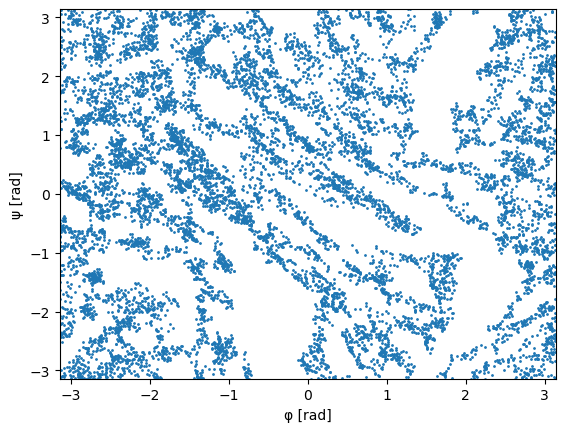

In [38]:
cvs_mtd = monitor_cvs_mtd.get_values()

plt.scatter(cvs_mtd[:, 0], cvs_mtd[:, 1], s=1)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel('φ [rad]')
plt.ylabel('ψ [rad]')
;

## 6. Semiempirical PM6 potential energy surface

### 6.1. Construct the training and test datasets

#### Get the biased mtd trajectory

In [39]:
mtd_traj = Trajectory("mtd.traj")

#### Set up the PM6 potential

In [40]:
# sander has been previously set up so we need to clean it up
if sander.is_setup():
    sander.cleanup()
# setup a SANDER calculator
mm_options = sander.gas_input(5)
mm_options.ifqnt = 1
qm_options = sander.qm_input()
qm_options.qm_theory = "PM6"
qm_options.qmmask = "@*"
qm_options.qmcharge = 0
qm_options.qmgb = 2
calc_pm6 = SANDER(atoms=atoms, top=top, crd=crd, mm_options=mm_options, qm_options=qm_options)
# set the Atoms object calculator
atoms.set_calculator(calc_pm6)

#### Randomize indexes and construct the training (with 10k configurations) and test (with 1k configurations) datasets

In [41]:
indexes = torch.randperm(11000, generator=torch.Generator().manual_seed(314159265))
indexes_train = indexes.tolist()[:10000]
indexes_test = indexes.tolist()[10000:]

#### Check training / test configurations

''

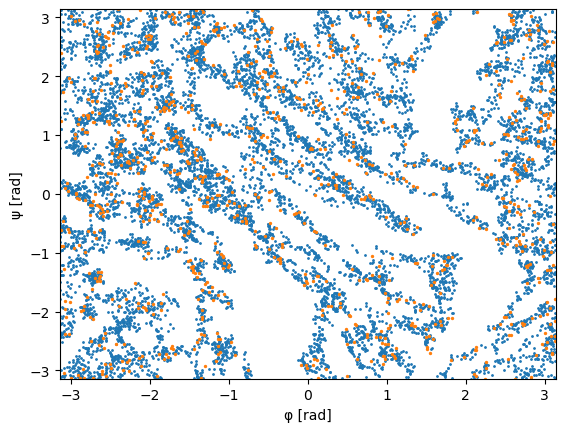

In [42]:
plt.scatter(cvs_mtd[indexes_train, 0], cvs_mtd[indexes_train, 1], s=1)
plt.scatter(cvs_mtd[indexes_test, 0], cvs_mtd[indexes_test, 1], s=2)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel('φ [rad]')
plt.ylabel('ψ [rad]')
;

#### Compute energy and force of training and test configurations

In [43]:
q_train = []
e_train = []
f_train = []

for idx in tqdm.tqdm(indexes_train):
    q_train.append(mtd_traj[idx].get_positions())
    e_train.append(calc_pm6.get_potential_energy(mtd_traj[idx]))
    f_train.append(calc_pm6.get_forces(mtd_traj[idx]))
    
q_train = torch.tensor(np.array(q_train), dtype=dt)
e_train = torch.tensor(np.array(e_train), dtype=dt)
f_train = torch.tensor(np.array(f_train), dtype=dt)

q_test = []
e_test = []
f_test = []

for idx in tqdm.tqdm(indexes_test):
    q_test.append(mtd_traj[idx].get_positions())
    e_test.append(calc_pm6.get_potential_energy(mtd_traj[idx]))
    f_test.append(calc_pm6.get_forces(mtd_traj[idx]))
    
q_test = torch.tensor(np.array(q_test), dtype=dt)
e_test = torch.tensor(np.array(e_test), dtype=dt)
f_test = torch.tensor(np.array(f_test), dtype=dt)

e_train_mean = e_train.mean()
e_train -= e_train_mean
e_test -= e_train_mean

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.75it/s]


### 6.2. Loss functions

In [44]:
# Mean squared error (MSE)
mse_loss = torch.nn.MSELoss()
# Mean absolute error (MAE)
mae_loss = torch.nn.L1Loss()

### 6.3. Descriptors

In [45]:
class DisVec(torch.nn.Module):
    def __init__(self, idx=None):
        super(DisVec, self).__init__()
        self.idx = idx
    
    def forward(self, qs):
        qs = qs.reshape(-1, qs.shape[-2], qs.shape[-1])
        G = qs @ qs.transpose(1, 2)
        g = torch.diagonal(G, dim1=1, dim2=2)
        D = g.reshape(g.shape[0], 1, g.shape[1]) + g.reshape(g.shape[0], g.shape[1], 1) - 2*G
        D = torch.sqrt(D + 1.0e-40)
        if self.idx is None:
            idx = torch.tril_indices(D.shape[1], D.shape[2], offset=-1)
        else:
            idx = self.idx
        return D[:, idx[0], idx[1]]

## 7. Gaussian process regression (GPR)

#### Kernel classes

- Descriptor: $\mathbf{x}(\mathbf{q}) \in \mathbb{R}^{D}$ 

- Squared exponential kernel:
$k^{\mathrm{SE}}(\mathbf{q}_{i}, \mathbf{q}_{j} | \delta, \boldsymbol{\theta)} = \delta^{2} \exp \left(-\frac{1}{2} \sum \limits_{k}^{D} \frac{(x^{(k)}(\mathbf{q}_{i}) - x^{(k)}(\mathbf{q}_{j}))^{2}}{\theta_{k}^{2}} \right)$
- Periodic squared exponential kernel:
$k^{\mathrm{PSE}}(\mathbf{q}_{i}, \mathbf{q}_{j} | \delta, \boldsymbol{\theta}, \mathbf{p}) = \delta^{2} \exp \left(-2 \sum \limits_{k}^{D} \frac{\sin^{2}\left(\frac{\pi}{p_{k}} (x^{(k)}(\mathbf{q}_{i}) - x^{(k)}(\mathbf{q}_{j}))\right)}{\theta_{k}^{2}} \right)$

In [46]:
class SEKernel(torch.nn.Module):
    def __init__(self, descriptor=torch.nn.Identity()):
        super(SEKernel, self).__init__()
        self.descriptor = descriptor

    def forward(self, qi, qj, delta, thetas):
        d = (torch.flatten(self.descriptor(qi)) - torch.flatten(self.descriptor(qj))) / thetas
        return torch.square(delta) * torch.exp(-0.5 * torch.dot(d, d))
    
class PSEKernel(torch.nn.Module):
    def __init__(self, descriptor=torch.nn.Identity()):
        super(PSEKernel, self).__init__()
        self.descriptor = descriptor

    def forward(self, qi, qj, delta, thetas, periodicities):
        d = (torch.flatten(self.descriptor(qi)) - torch.flatten(self.descriptor(qj))) * torch.pi / periodicities
        return torch.square(delta) * torch.exp(-2.0 * torch.sum(torch.square(torch.sin(d) / thetas)))

In [47]:
dis = DisVec()
dis_train = dis(q_train)
dis_means = torch.mean(dis_train, dim=0, keepdim=True)[0]
dis_stds = torch.std(dis_train, dim=0, keepdim=True)[0]
dis_dim = dis_train.shape[1]

In [48]:
kernel = SEKernel(dis)

### 7.1. Full GPR

- Training from: *energy* or *force* or *energy+force*
- Predicting: *energy* and *force*

In [49]:
class FullGPR:
    def __init__(self, kernel, q_train, trainig_type=None, e_train=None, f_train=None):
        self.kernel = kernel
        self.dkerneldq1 = lambda q1, q2, *params: ft.jacrev(kernel, 0)(q1, q2, *params).flatten(start_dim=0)
        self.dkerneldq2 = lambda q1, q2, *params: ft.jacrev(kernel, 1)(q1, q2, *params).flatten(start_dim=0)
        self.d2kerneldq1dq2 = lambda q1, q2, *params: ft.jacfwd(self.dkerneldq1, 1)(q1, q2, *params).flatten(start_dim=1)
        self.q_train = q_train
        if trainig_type == "energy":
            self.y_train = e_train.reshape(-1, 1)
        elif trainig_type == "force":
            self.y_train = -f_train.reshape(-1, 1)
        elif trainig_type == "energy+force":
            self.y_train = torch.cat((e_train, -f_train.flatten())).reshape(-1, 1)
        else:
            raise TypeError("trainig_type must be 'energy', 'force' or 'energy+force'.")
        self.trainig_type = trainig_type

    def kernel_ee(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.kernel(q1, q2, *params))(q2s))(q1s)
    
    def kernel_ef(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.dkerneldq2(q1, q2, *params))(q2s))(q1s).flatten(start_dim=1, end_dim=2)

    def kernel_fe(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.dkerneldq1(q1, q2, *params))(q2s))(q1s).permute(0, 2, 1).flatten(start_dim=0, end_dim=1)
 
    def kernel_ff(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.d2kerneldq1dq2(q1, q2, *params))(q2s))(q1s).permute(0, 2, 1, 3).flatten(start_dim=2, end_dim=3).flatten(start_dim=0, end_dim=1)

    def covariance_matrix(self, sigma_e, sigma_f, *params):
        if self.trainig_type == "energy":
            C = self.kernel_ee(self.q_train, self.q_train, *params)
            C[range(C.shape[0]), range(C.shape[1])] += torch.square(sigma_e)
        elif self.trainig_type == "force":
            C = self.kernel_ff(self.q_train, self.q_train, *params)
            C[range(C.shape[0]), range(C.shape[1])] += torch.square(sigma_f)
        elif self.trainig_type == "energy+force":
            K_ee = self.kernel_ee(self.q_train, self.q_train, *params)
            K_ef = self.kernel_ef(self.q_train, self.q_train, *params)
            K_ff = self.kernel_ff(self.q_train, self.q_train, *params)
            K_ee[range(K_ee.shape[0]), range(K_ee.shape[1])] += torch.square(sigma_e)
            K_ff[range(K_ff.shape[0]), range(K_ff.shape[1])] += torch.square(sigma_f)
            C = torch.cat((torch.cat((K_ee, K_ef), dim=1), torch.cat((K_ef.T, K_ff), dim=1)), dim=0)
        C[range(C.shape[0]), range(C.shape[1])] += torch.tensor(1.0e-6)
        return C
        
    def set_parameters(self, *params, sigma_e=None, sigma_f=None):
        self.params = params
        C = self.covariance_matrix(sigma_e, sigma_f, *params)
        self.Cinv_y = torch.linalg.solve_ex(C, self.y_train)[0].flatten()
        
    def negative_log_marginal_likelihood(self, *params, sigma_e=None, sigma_f=None):
        C = self.covariance_matrix(sigma_e, sigma_f, *params)
        L = torch.linalg.cholesky_ex(C).L
        z = torch.linalg.solve_triangular(L, self.y_train, upper=False).flatten()
        self.L = L
        return C.shape[0] / 2 * torch.log(torch.tensor(2*torch.pi)) + torch.sum(torch.log(torch.diag(L))) + torch.dot(z, z) / 2
    
    def predict_e(self, q_test):
        if self.trainig_type == "energy":
            k = self.kernel_ee(q_test, self.q_train, *self.params)
        elif self.trainig_type == "force":
            k = self.kernel_ef(q_test, self.q_train, *self.params)
        elif self.trainig_type == "energy+force":
            k_ee = self.kernel_ee(q_test, self.q_train, *self.params)
            k_ef = self.kernel_ef(q_test, self.q_train, *self.params)
            k = torch.cat((k_ee, k_ef), dim=1)
        return k @ self.Cinv_y
    
    def predict_f(self, q_test):
        if self.trainig_type == "energy":
            k = self.kernel_fe(q_test, self.q_train, *self.params)
        elif self.trainig_type == "force":
            k = self.kernel_ff(q_test, self.q_train, *self.params)
        elif self.trainig_type == "energy+force":
            k_fe = self.kernel_fe(q_test, self.q_train, *self.params)
            k_ff = self.kernel_ff(q_test, self.q_train, *self.params)
            k = torch.cat((k_fe, k_ff), dim=1)
        return -(k @ self.Cinv_y).reshape(q_test.shape[0], q_test.shape[1], q_test.shape[2])

#### Training only from energy

In [50]:
# number of training samples
N = 1000
# number of test samples
T = 100

In [51]:
# create the gpr object
gpr = FullGPR(kernel, q_train[:N], trainig_type="energy", e_train=e_train[:N])
# set the parameters
delta = torch.tensor(1.0)
thetas = dis_dim * dis_stds
sigma_e = torch.tensor(0.001)
gpr.set_parameters(delta, thetas, sigma_e=sigma_e)

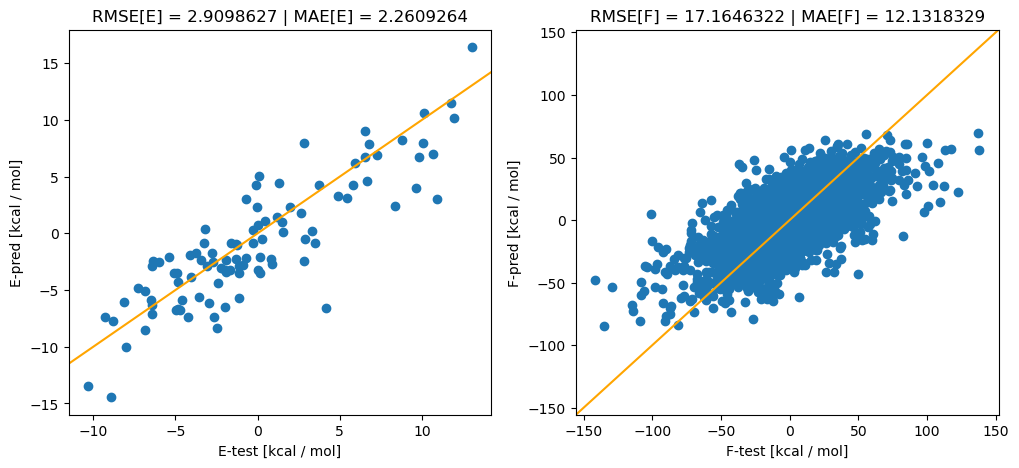

In [52]:
e_t = e_test[:T] * units.mol/units.kcal
e_p = gpr.predict_e(q_test[:T]) * units.mol/units.kcal
e_rmse_loss = torch.sqrt(mse_loss(e_p, e_t))
e_mae_loss = mae_loss(e_p, e_t)
f_t = f_test[:T].flatten() * units.mol/units.kcal
f_p = gpr.predict_f(q_test[:T]).flatten() * units.mol/units.kcal
f_rmse_loss = torch.sqrt(mse_loss(f_p, f_t))
f_mae_loss = mae_loss(f_p, f_t)

fig, (fig1, fig2) = plt.subplots(ncols=2, figsize=(12, 5))
fig1.scatter(e_t, e_p)
fig1.axline((torch.min(e_t), torch.min(e_t)), (torch.max(e_t), torch.max(e_t)), c="orange")
fig1.set_xlabel('E-test [kcal / mol]')
fig1.set_ylabel('E-pred [kcal / mol]')
fig1.set_title("RMSE[E] = " + "%8.7f" % e_rmse_loss + " | MAE[E] = " + "%8.7f" % e_mae_loss)
fig2.scatter(f_t, f_p)
fig2.axline((torch.min(f_t), torch.min(f_t)), (torch.max(f_t), torch.max(f_t)), c="orange")
fig2.set_xlabel('F-test [kcal / mol]')
fig2.set_ylabel('F-pred [kcal / mol]')
fig2.set_title("RMSE[F] = " + "%8.7f" % f_rmse_loss + " | MAE[F] = " + "%8.7f" % f_mae_loss)
fig.show()

#### Training from energy+force

In [53]:
# number of training samples
N = 100
# number of test samples
T = 100

In [54]:
# create the gpr object
gpr = FullGPR(kernel, q_train[:N], trainig_type="energy+force", e_train=e_train[:N], f_train=f_train[:N])
# set the parameters
delta = torch.tensor(1.0)
thetas = dis_dim * dis_stds
sigma_e = torch.tensor(0.001)
sigma_f = torch.tensor(0.001)
gpr.set_parameters(delta, thetas, sigma_e=sigma_e, sigma_f=sigma_f)

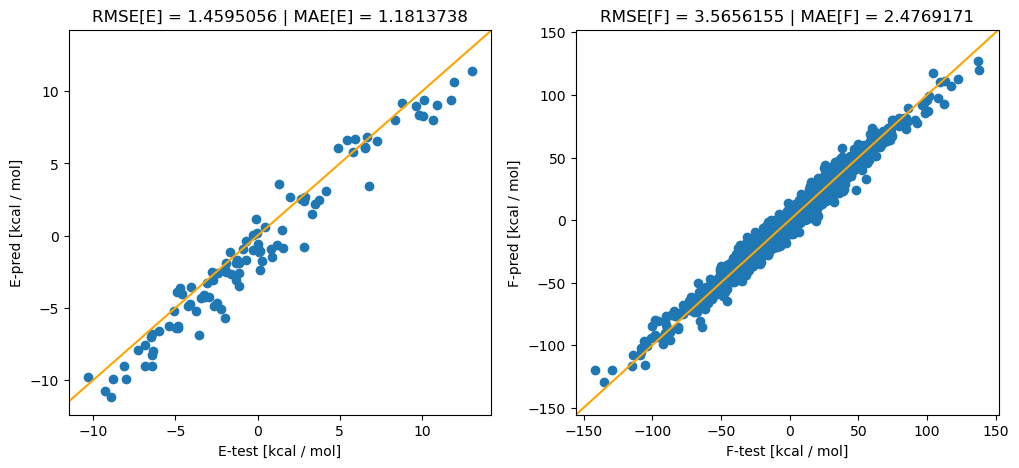

In [55]:
e_t = e_test[:T] * units.mol/units.kcal
e_p = gpr.predict_e(q_test[:T]) * units.mol/units.kcal
e_rmse_loss = torch.sqrt(mse_loss(e_p, e_t))
e_mae_loss = mae_loss(e_p, e_t)
f_t = f_test[:T].flatten() * units.mol/units.kcal
f_p = gpr.predict_f(q_test[:T]).flatten() * units.mol/units.kcal
f_rmse_loss = torch.sqrt(mse_loss(f_p, f_t))
f_mae_loss = mae_loss(f_p, f_t)

fig, (fig1, fig2) = plt.subplots(ncols=2, figsize=(12, 5))
fig1.scatter(e_t, e_p)
fig1.axline((torch.min(e_t), torch.min(e_t)), (torch.max(e_t), torch.max(e_t)), c="orange")
fig1.set_xlabel('E-test [kcal / mol]')
fig1.set_ylabel('E-pred [kcal / mol]')
fig1.set_title("RMSE[E] = " + "%8.7f" % e_rmse_loss + " | MAE[E] = " + "%8.7f" % e_mae_loss)
fig2.scatter(f_t, f_p)
fig2.axline((torch.min(f_t), torch.min(f_t)), (torch.max(f_t), torch.max(f_t)), c="orange")
fig2.set_xlabel('F-test [kcal / mol]')
fig2.set_ylabel('F-pred [kcal / mol]')
fig2.set_title("RMSE[F] = " + "%8.7f" % f_rmse_loss + " | MAE[F] = " + "%8.7f" % f_mae_loss)
fig.show()

#### Reducing the input dimension

In [56]:
dis_dim

231

In [57]:
idx = []
for bond in top.bonds:
    idx.append([bond.atom1.idx, bond.atom2.idx])
for angle in top.angles:
    idx.append([angle.atom1.idx, angle.atom3.idx])
for dihedral in top.dihedrals:
    idx.append([dihedral.atom1.idx, dihedral.atom4.idx])
idx = torch.tensor(idx).T

In [58]:
disred = DisVec(idx)
disred_train = disred(q_train)
disred_means = torch.mean(disred_train, dim=0, keepdim=True)[0]
disred_stds = torch.std(disred_train, dim=0, keepdim=True)[0]
disred_dim = disred_train.shape[1]

In [59]:
disred_dim

124

In [60]:
kernel = SEKernel(disred)

In [61]:
# number of training samples
N = 100
# number of test samples
T = 100

In [62]:
# create the gpr object
gpr = FullGPR(kernel, q_train[:N], trainig_type="energy+force", e_train=e_train[:N], f_train=f_train[:N])
# set the parameters
delta = torch.tensor(1.0)
thetas = disred_dim * disred_stds
sigma_e = torch.tensor(0.001)
sigma_f = torch.tensor(0.001)
gpr.set_parameters(delta, thetas, sigma_e=sigma_e, sigma_f=sigma_f)

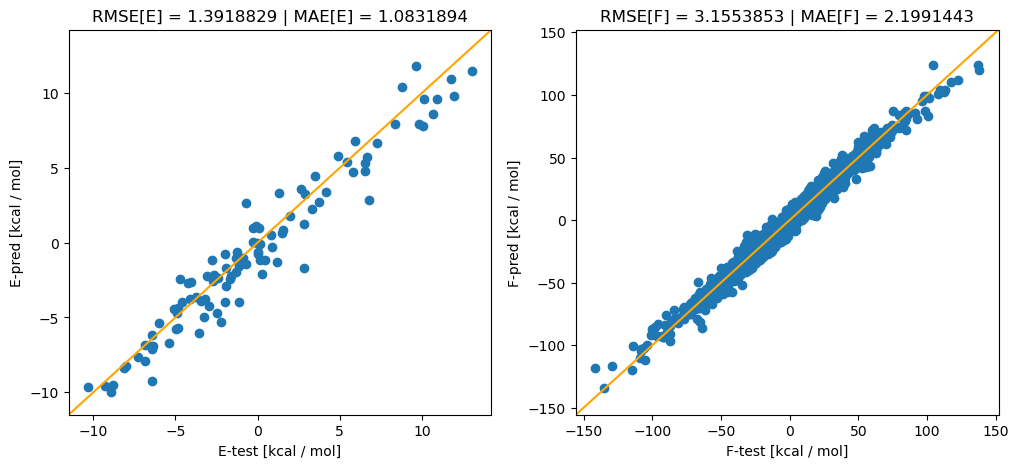

In [63]:
e_t = e_test[:T] * units.mol/units.kcal
e_p = gpr.predict_e(q_test[:T]) * units.mol/units.kcal
e_rmse_loss = torch.sqrt(mse_loss(e_p, e_t))
e_mae_loss = mae_loss(e_p, e_t)
f_t = f_test[:T].flatten() * units.mol/units.kcal
f_p = gpr.predict_f(q_test[:T]).flatten() * units.mol/units.kcal
f_rmse_loss = torch.sqrt(mse_loss(f_p, f_t))
f_mae_loss = mae_loss(f_p, f_t)

fig, (fig1, fig2) = plt.subplots(ncols=2, figsize=(12, 5))
fig1.scatter(e_t, e_p)
fig1.axline((torch.min(e_t), torch.min(e_t)), (torch.max(e_t), torch.max(e_t)), c="orange")
fig1.set_xlabel('E-test [kcal / mol]')
fig1.set_ylabel('E-pred [kcal / mol]')
fig1.set_title("RMSE[E] = " + "%8.7f" % e_rmse_loss + " | MAE[E] = " + "%8.7f" % e_mae_loss)
fig2.scatter(f_t, f_p)
fig2.axline((torch.min(f_t), torch.min(f_t)), (torch.max(f_t), torch.max(f_t)), c="orange")
fig2.set_xlabel('F-test [kcal / mol]')
fig2.set_ylabel('F-pred [kcal / mol]')
fig2.set_title("RMSE[F] = " + "%8.7f" % f_rmse_loss + " | MAE[F] = " + "%8.7f" % f_mae_loss)
fig.show()

### 7.2. Sparse GPR

- Specifying *sparse points*
- Training from: *energy* or *force* or *energy+force*
- Predicting: *energy* and *force*

In [64]:
class DTCGPR:
    def __init__(self, kernel, q_sparse, q_train, trainig_type=None, e_train=None, f_train=None):
        self.kernel = kernel
        self.dkerneldq1 = lambda q1, q2, *params: ft.jacrev(kernel, 0)(q1, q2, *params).flatten(start_dim=0)
        self.dkerneldq2 = lambda q1, q2, *params: ft.jacrev(kernel, 1)(q1, q2, *params).flatten(start_dim=0)
        self.d2kerneldq1dq2 = lambda q1, q2, *params: ft.jacfwd(self.dkerneldq1, 1)(q1, q2, *params).flatten(start_dim=1)
        self.q_sparse = q_sparse
        self.q_train = q_train
        if trainig_type == "energy":
            self.y_train = e_train.reshape(-1, 1)
        elif trainig_type == "force":
            self.y_train = -f_train.reshape(-1, 1)
        elif trainig_type == "energy+force":
            self.y_train = torch.cat((e_train, -f_train.flatten())).reshape(-1, 1)
        else:
            raise TypeError("trainig_type must be 'energy', 'force' or 'energy+force'.")
        self.trainig_type = trainig_type

    def kernel_ee(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.kernel(q1, q2, *params))(q2s))(q1s)
    
    def kernel_ef(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.dkerneldq2(q1, q2, *params))(q2s))(q1s).flatten(start_dim=1, end_dim=2)

    def kernel_fe(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.dkerneldq1(q1, q2, *params))(q2s))(q1s).permute(0, 2, 1).flatten(start_dim=0, end_dim=1)
 
    def kernel_ff(self, q1s, q2s, *params):
        return ft.vmap(lambda q1: ft.vmap(lambda q2: self.d2kerneldq1dq2(q1, q2, *params))(q2s))(q1s).permute(0, 2, 1, 3).flatten(start_dim=2, end_dim=3).flatten(start_dim=0, end_dim=1)
    
    def covariance_matrices(self, sigma, *params):
        if self.trainig_type == "energy":
            K_uu = self.kernel_ee(self.q_sparse, self.q_sparse, *params)
            K_uf = self.kernel_ee(self.q_sparse, self.q_train, *params)
        elif self.trainig_type == "force":
            K_uu = self.kernel_ff(self.q_sparse, self.q_sparse, *params)
            K_uf = self.kernel_ff(self.q_sparse, self.q_train, *params)
        elif self.trainig_type == "energy+force":
            K_uu_ee = self.kernel_ee(self.q_sparse, self.q_sparse, *params)
            K_uu_ef = self.kernel_ef(self.q_sparse, self.q_sparse, *params)
            K_uu_ff = self.kernel_ff(self.q_sparse, self.q_sparse, *params)
            K_uu = torch.cat((torch.cat((K_uu_ee, K_uu_ef), dim=1), torch.cat((K_uu_ef.T, K_uu_ff), dim=1)), dim=0)
            K_uf_ee = self.kernel_ee(self.q_sparse, self.q_train, *params)
            K_uf_ef = self.kernel_ef(self.q_sparse, self.q_train, *params)
            K_uf_fe = self.kernel_fe(self.q_sparse, self.q_train, *params)
            K_uf_ff = self.kernel_ff(self.q_sparse, self.q_train, *params)
            K_uf = torch.cat((torch.cat((K_uf_ee, K_uf_ef), dim=1), torch.cat((K_uf_fe, K_uf_ff), dim=1)), dim=0)
        C = torch.square(sigma) * K_uu + K_uf @ K_uf.T
        K_uu[range(K_uu.shape[0]), range(K_uu.shape[1])] += torch.tensor(1.0e-6)
        C[range(C.shape[0]), range(C.shape[1])] += torch.tensor(1.0e-6)
        return C, K_uu, K_uf
        
    def set_parameters(self, *params, sigma=None):
        self.params = params
        C, K_uu, K_uf = self.covariance_matrices(sigma, *params)
        self.Cinv_K_uf_y = torch.linalg.solve_ex(C, K_uf @ self.y_train)[0].flatten()
        
    def negative_log_marginal_likelihood(self, *params, sigma=None):
        C, K_uu, K_uf = self.covariance_matrices(sigma, *params)
        L_uu = torch.linalg.cholesky_ex(K_uu).L
        L = torch.linalg.cholesky_ex(C).L
        z = torch.linalg.solve_triangular(L, K_uf @ self.y_train, upper=False).flatten()
    
        return K_uf.shape[1] / 2 * torch.log(torch.tensor(2*torch.pi)) \
            + (K_uf.shape[1] - K_uf.shape[0]) * torch.log(torch.square(sigma)) / 2 \
            + torch.sum(torch.log(torch.diag(L))) - torch.sum(torch.log(torch.diag(L_uu))) \
            + 1 / torch.square(sigma) * (torch.dot(self.y_train.flatten(), self.y_train.flatten()) - torch.dot(z, z)) / 2
    
    def predict_e(self, q_test):
        if self.trainig_type == "energy":
            k = self.kernel_ee(q_test, self.q_sparse, *self.params)
        elif self.trainig_type == "force":
            k = self.kernel_ef(q_test, self.q_sparse, *self.params)
        elif self.trainig_type == "energy+force":
            k_ee = self.kernel_ee(q_test, self.q_sparse, *self.params)
            k_ef = self.kernel_ef(q_test, self.q_sparse, *self.params)
            k = torch.cat((k_ee, k_ef), dim=1)
        return k @ self.Cinv_K_uf_y
    
    def predict_f(self, q_test):
        if self.trainig_type == "energy":
            k = self.kernel_fe(q_test, self.q_sparse, *self.params)
        elif self.trainig_type == "force":
            k = self.kernel_ff(q_test, self.q_sparse, *self.params)
        elif self.trainig_type == "energy+force":
            k_fe = self.kernel_fe(q_test, self.q_sparse, *self.params)
            k_ff = self.kernel_ff(q_test, self.q_sparse, *self.params)
            k = torch.cat((k_fe, k_ff), dim=1)
        return -(k @ self.Cinv_K_uf_y).reshape(q_test.shape[0], q_test.shape[1], q_test.shape[2])

In [65]:
# number of sparse samples
S = 50
# number of training samples
N = 200
# number of test samples
T = 100

In [66]:
# create the gpr object
gpr = DTCGPR(kernel, q_train[:S], q_train[:N], trainig_type="force", f_train=f_train[:N])
# set the parameters
delta = torch.tensor(1.0)
thetas = disred_dim * disred_stds
sigma = torch.tensor(0.001)
gpr.set_parameters(delta, thetas, sigma=sigma)
# compute the energy shift
c = torch.mean(e_train[:N] - gpr.predict_e(q_train[:N])) * units.mol/units.kcal

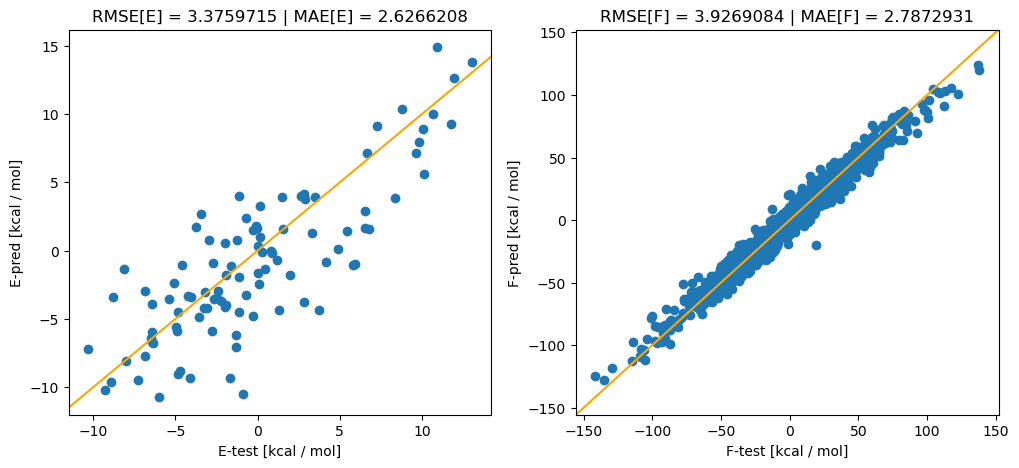

In [67]:
e_t = e_test[:T] * units.mol/units.kcal
e_p = gpr.predict_e(q_test[:T]) * units.mol/units.kcal + c
e_rmse_loss = torch.sqrt(mse_loss(e_p, e_t))
e_mae_loss = mae_loss(e_p, e_t)
f_t = f_test[:T].flatten() * units.mol/units.kcal
f_p = gpr.predict_f(q_test[:T]).flatten() * units.mol/units.kcal
f_rmse_loss = torch.sqrt(mse_loss(f_p, f_t))
f_mae_loss = mae_loss(f_p, f_t)

fig, (fig1, fig2) = plt.subplots(ncols=2, figsize=(12, 5))
fig1.scatter(e_t, e_p)
fig1.axline((torch.min(e_t), torch.min(e_t)), (torch.max(e_t), torch.max(e_t)), c="orange")
fig1.set_xlabel('E-test [kcal / mol]')
fig1.set_ylabel('E-pred [kcal / mol]')
fig1.set_title("RMSE[E] = " + "%8.7f" % e_rmse_loss + " | MAE[E] = " + "%8.7f" % e_mae_loss)
fig2.scatter(f_t, f_p)
fig2.axline((torch.min(f_t), torch.min(f_t)), (torch.max(f_t), torch.max(f_t)), c="orange")
fig2.set_xlabel('F-test [kcal / mol]')
fig2.set_ylabel('F-pred [kcal / mol]')
fig2.set_title("RMSE[F] = " + "%8.7f" % f_rmse_loss + " | MAE[F] = " + "%8.7f" % f_mae_loss)
fig.show()

## 8. Neural networks

### 8.1. Create an NN class

In [68]:
class NN(torch.nn.Module):
    def __init__(self, descriptor, descriptor_dim, means=0, stds=1):
        super(NN, self).__init__()
        self.descriptor = descriptor
        self.means = means
        self.stds = stds
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(descriptor_dim, 256, dtype=dt),
            torch.nn.GELU(),
            torch.nn.Linear(256, 512, dtype=dt),
            torch.nn.GELU(),
            torch.nn.Linear(512, 512, dtype=dt),
            torch.nn.GELU(),
            torch.nn.Linear(512, 1, dtype=dt),
        )

    def forward(self, q):
        return self.seq((self.descriptor(q)-self.means)/self.stds)

### 8.2. Setup for mini-batch

In [69]:
# we use all training data, i.e. 10,000 samples
data = torch.utils.data.TensorDataset(q_train, e_train.view(-1, 1), f_train)
# mini-batch size is 100
batch_size = 100
# for each epoch, shuffle the samples in order to get better convergence
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

### 8.3. Training from energy

#### Model and optimizer setup

In [70]:
model = NN(dis, dis_dim, dis_means, dis_stds)
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

#### Training

In [71]:
for epoch in range(50):
    model.train()
    
    for (q_batch, e_batch, f_batch) in loader:
    
        optimizer.zero_grad(set_to_none=True)
        e_pred = model(q_batch)
        loss = mse_loss(e_pred, e_batch)
                 
        loss.backward()
        optimizer.step()
    
    model.eval()
    e_pred, g_pred = F.vjp(model, q_train, torch.ones(q_train.shape[0], 1))
    e_rmse_loss = torch.sqrt(mse_loss(e_pred, e_train.view(-1, 1)))
    e_mae_loss = mae_loss(e_pred, e_train.view(-1, 1))
    f_rmse_loss = torch.sqrt(mse_loss(-g_pred, f_train))
    f_mae_loss = mae_loss(-g_pred, f_train)
    
    print("epoch = " + "%5d" % (epoch + 1) + 
          " | RMSE[E] = " + "%8.7f" % (e_rmse_loss * units.mol/units.kcal) + 
          " | MAE[E] = " + "%8.7f" % (e_mae_loss * units.mol/units.kcal) + 
          " | RMSE[F] = " + "%8.7f" % (f_rmse_loss * units.mol/units.kcal) +
          " | MAE[F] = " + "%8.7f" % (f_mae_loss * units.mol/units.kcal)
    )

epoch =     1 | RMSE[E] = 2.7961657 | MAE[E] = 2.2536484 | RMSE[F] = 15.7349706 | MAE[F] = 11.3208339
epoch =     2 | RMSE[E] = 2.1661303 | MAE[E] = 1.7148908 | RMSE[F] = 13.8120213 | MAE[F] = 9.9406563
epoch =     3 | RMSE[E] = 1.8910889 | MAE[E] = 1.5199877 | RMSE[F] = 11.9371019 | MAE[F] = 8.5952847
epoch =     4 | RMSE[E] = 1.9366787 | MAE[E] = 1.5461856 | RMSE[F] = 11.2348371 | MAE[F] = 8.0731661
epoch =     5 | RMSE[E] = 1.5537351 | MAE[E] = 1.2315714 | RMSE[F] = 10.6436497 | MAE[F] = 7.6274281
epoch =     6 | RMSE[E] = 1.4960855 | MAE[E] = 1.1976296 | RMSE[F] = 10.2871748 | MAE[F] = 7.3556586
epoch =     7 | RMSE[E] = 1.3417918 | MAE[E] = 1.0717617 | RMSE[F] = 9.1243105 | MAE[F] = 6.5238921
epoch =     8 | RMSE[E] = 1.2245988 | MAE[E] = 0.9719150 | RMSE[F] = 8.7606411 | MAE[F] = 6.2847665
epoch =     9 | RMSE[E] = 1.1991367 | MAE[E] = 0.9587561 | RMSE[F] = 8.5966289 | MAE[F] = 6.1587560
epoch =    10 | RMSE[E] = 1.0896280 | MAE[E] = 0.8655299 | RMSE[F] = 8.0748227 | MAE[F] = 5.7

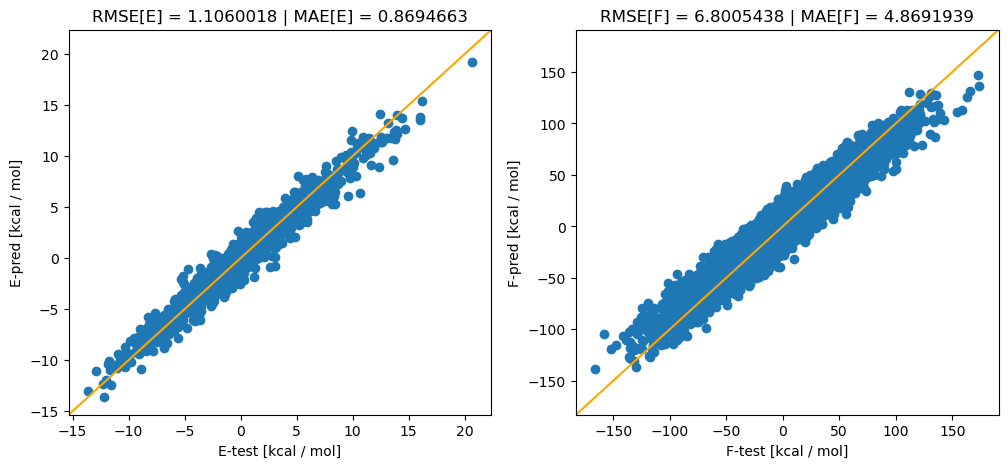

In [72]:
# use model in evaluation mode
model.eval()
e_t = e_test.view(-1, 1) * units.mol/units.kcal
f_t = f_test.flatten() * units.mol/units.kcal
e_p, g_p = F.vjp(model, q_test, torch.ones(q_test.shape[0], 1))
e_p = e_p * units.mol/units.kcal
f_p = -g_p.flatten() * units.mol/units.kcal
e_rmse_loss = torch.sqrt(mse_loss(e_p, e_t))
e_mae_loss = mae_loss(e_p, e_t)
f_rmse_loss = torch.sqrt(mse_loss(f_p, f_t))
f_mae_loss = mae_loss(f_p, f_t)

fig, (fig1, fig2) = plt.subplots(ncols=2, figsize=(12, 5))
fig1.scatter(e_t, e_p)
fig1.axline((torch.min(e_t), torch.min(e_t)), (torch.max(e_t), torch.max(e_t)), c="orange")
fig1.set_xlabel('E-test [kcal / mol]')
fig1.set_ylabel('E-pred [kcal / mol]')
fig1.set_title("RMSE[E] = " + "%8.7f" % e_rmse_loss + " | MAE[E] = " + "%8.7f" % e_mae_loss)
fig2.scatter(f_t, f_p)
fig2.axline((torch.min(f_t), torch.min(f_t)), (torch.max(f_t), torch.max(f_t)), c="orange")
fig2.set_xlabel('F-test [kcal / mol]')
fig2.set_ylabel('F-pred [kcal / mol]')
fig2.set_title("RMSE[F] = " + "%8.7f" % f_rmse_loss + " | MAE[F] = " + "%8.7f" % f_mae_loss)
fig.show()

### 8.4. Training from energy+force

#### Model and optimizer setup

In [73]:
model = NN(dis, dis_dim, dis_means, dis_stds)
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

#### Training

In [74]:
for epoch in range(50):
    
    model.train()
        
    for (q_batch, e_batch, f_batch) in loader:
    
        optimizer.zero_grad(set_to_none=True)
        e_pred, g_pred = F.vjp(model, q_batch, torch.ones(q_batch.size()[0], 1), create_graph=True)
        e_mse_loss = mse_loss(e_pred, e_batch)
        f_mse_loss = mse_loss(-g_pred, f_batch)
        loss = e_mse_loss + f_mse_loss
                 
        loss.backward()
        optimizer.step()
    
    model.eval()
    e_pred, g_pred = F.vjp(model, q_train, torch.ones(q_train.size()[0], 1))
    e_rmse_loss = torch.sqrt(mse_loss(e_pred, e_train.view(-1, 1)))
    e_mae_loss = mae_loss(e_pred, e_train.view(-1, 1))
    f_rmse_loss = torch.sqrt(mse_loss(-g_pred, f_train))
    f_mae_loss = mae_loss(-g_pred, f_train)
    
    print("epoch = " + "%5d" % (epoch + 1) + 
          " | RMSE[E] = " + "%8.7f" % (e_rmse_loss * units.mol/units.kcal) + 
          " | MAE[E] = " + "%8.7f" % (e_mae_loss * units.mol/units.kcal) + 
          " | RMSE[F] = " + "%8.7f" % (f_rmse_loss * units.mol/units.kcal) +
          " | MAE[F] = " + "%8.7f" % (f_mae_loss * units.mol/units.kcal)
    )

epoch =     1 | RMSE[E] = 1.3592477 | MAE[E] = 1.0756942 | RMSE[F] = 3.8853991 | MAE[F] = 2.8201550
epoch =     2 | RMSE[E] = 0.9799850 | MAE[E] = 0.7735329 | RMSE[F] = 2.9803057 | MAE[F] = 2.1496238
epoch =     3 | RMSE[E] = 0.9195327 | MAE[E] = 0.7354509 | RMSE[F] = 2.7815184 | MAE[F] = 1.9901365
epoch =     4 | RMSE[E] = 1.0235635 | MAE[E] = 0.8094543 | RMSE[F] = 2.5261148 | MAE[F] = 1.8099691
epoch =     5 | RMSE[E] = 0.7451920 | MAE[E] = 0.5872455 | RMSE[F] = 2.5067577 | MAE[F] = 1.7861402
epoch =     6 | RMSE[E] = 0.8366221 | MAE[E] = 0.6681959 | RMSE[F] = 2.2278427 | MAE[F] = 1.6001142
epoch =     7 | RMSE[E] = 0.7590652 | MAE[E] = 0.6087212 | RMSE[F] = 2.1776211 | MAE[F] = 1.5788779
epoch =     8 | RMSE[E] = 0.7102605 | MAE[E] = 0.5617411 | RMSE[F] = 2.0596192 | MAE[F] = 1.5089543
epoch =     9 | RMSE[E] = 0.9447106 | MAE[E] = 0.7621390 | RMSE[F] = 2.0285052 | MAE[F] = 1.4894706
epoch =    10 | RMSE[E] = 0.7574949 | MAE[E] = 0.6014025 | RMSE[F] = 1.9858332 | MAE[F] = 1.4482070


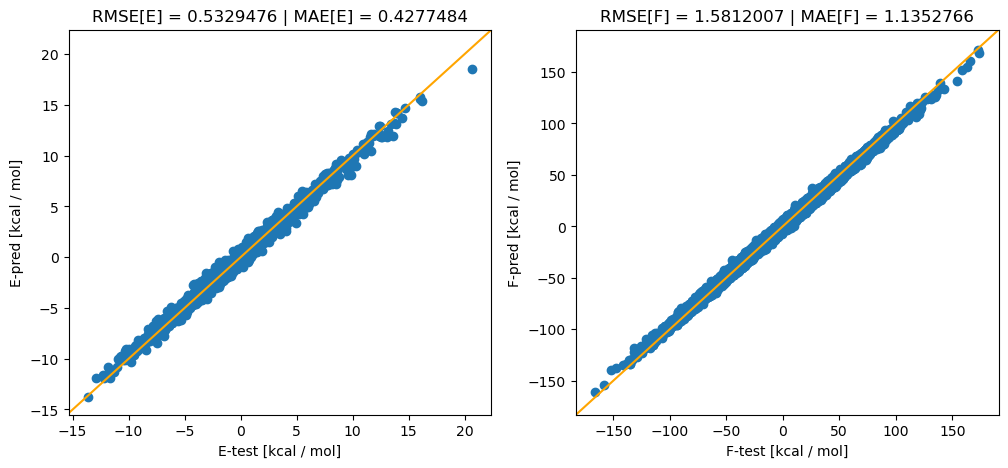

In [75]:
# use model in evaluation mode
model.eval()
e_t = e_test.view(-1, 1) * units.mol/units.kcal
f_t = f_test.flatten() * units.mol/units.kcal
e_p, g_p = F.vjp(model, q_test, torch.ones(q_test.shape[0], 1))
e_p = e_p * units.mol/units.kcal
f_p = -g_p.flatten() * units.mol/units.kcal
e_rmse_loss = torch.sqrt(mse_loss(e_p, e_t))
e_mae_loss = mae_loss(e_p, e_t)
f_rmse_loss = torch.sqrt(mse_loss(f_p, f_t))
f_mae_loss = mae_loss(f_p, f_t)

fig, (fig1, fig2) = plt.subplots(ncols=2, figsize=(12, 5))
fig1.scatter(e_t, e_p)
fig1.axline((torch.min(e_t), torch.min(e_t)), (torch.max(e_t), torch.max(e_t)), c="orange")
fig1.set_xlabel('E-test [kcal / mol]')
fig1.set_ylabel('E-pred [kcal / mol]')
fig1.set_title("RMSE[E] = " + "%8.7f" % e_rmse_loss + " | MAE[E] = " + "%8.7f" % e_mae_loss)
fig2.scatter(f_t, f_p)
fig2.axline((torch.min(f_t), torch.min(f_t)), (torch.max(f_t), torch.max(f_t)), c="orange")
fig2.set_xlabel('F-test [kcal / mol]')
fig2.set_ylabel('F-pred [kcal / mol]')
fig2.set_title("RMSE[F] = " + "%8.7f" % f_rmse_loss + " | MAE[F] = " + "%8.7f" % f_mae_loss)
fig.show()

## 9. Using the ML FF in simulations

#### Create an `NNPotential` class

In [76]:
class NNPotential(Calculator):
    implemented_properties=['energy', 'forces']
    
    def __init__(self, atoms=None, label=None, nn_model=None, dtype=torch.float64):
        Calculator.__init__(self, label, atoms)
        self.nn_model = nn_model
        self.dtype = dtype
        
    def calculate(self, atoms, properties, system_changes):
        Calculator.calculate(self, atoms, properties, system_changes)
        if system_changes:
            for prop in self.implemented_properties:
                if prop in self.results:
                    del self.results[prop]
                
        a = atoms.copy()
        q = torch.tensor(a.get_positions(), dtype=self.dtype)
            
        e_pred, g_pred = F.vjp(self.nn_model, q)
        self.results['energy'] = e_pred.detach().numpy().item()
        self.results['forces'] = -g_pred.detach().numpy()

#### Set up an NN calculator

In [77]:
calc_nn = NNPotential(atoms, nn_model=model)

#### Set up an MTD object

In [78]:
mtd = MTD(
    atoms=atoms,
    calc=calc_nn,
    cvs=cvs,
    height=1.0*units.kcal/units.mol,
    widths=[np.pi/10, np.pi/10],
    periodicities=[2*np.pi, 2*np.pi],
    mtdtemp=100000,
    mtdstep=100
)
atoms.set_calculator(mtd)

#### Set up the dynamics object

In [79]:
dyn_mtd_nn = BAOAB(atoms=atoms, timestep=0.5*units.fs, T=300, friction=0.05, nscm=1000, rndseed=2718281828)

#### Attach monitoring objects

In [80]:
monitor_md_mtd_nn = MonitorMD(atoms, dyn_mtd_nn)
traj_mtd_nn = Trajectory('mtd_nn.traj', 'w', atoms=atoms)
monitor_cvs_mtd_nn = MonitorCVs(atoms, cvs)

dyn_mtd_nn.attach(monitor_md_mtd_nn.write, interval=1000)
dyn_mtd_nn.attach(traj_mtd_nn.write, interval=10)
dyn_mtd_nn.attach(monitor_cvs_mtd_nn.append, interval=10)

#### Run the MTD simulation on the NN surface

In [81]:
nstep = 100000

dyn_mtd_nn.run(nstep)

step =       0 |  E_pot = -2.941 |  E_kin = 16.898 |  E_tot = 13.957 |  T = 257.7
step =    1000 |  E_pot = -12.590 |  E_kin = 13.819 |  E_tot =  1.229 |  T = 210.7
step =    2000 |  E_pot = -0.121 |  E_kin = 19.086 |  E_tot = 18.966 |  T = 291.0
step =    3000 |  E_pot = -8.078 |  E_kin = 19.234 |  E_tot = 11.155 |  T = 293.3
step =    4000 |  E_pot =  1.534 |  E_kin = 18.848 |  E_tot = 20.383 |  T = 287.4
step =    5000 |  E_pot = -1.396 |  E_kin = 14.918 |  E_tot = 13.522 |  T = 227.5
step =    6000 |  E_pot = -2.185 |  E_kin = 22.731 |  E_tot = 20.546 |  T = 346.6
step =    7000 |  E_pot = -2.503 |  E_kin = 24.668 |  E_tot = 22.165 |  T = 376.2
step =    8000 |  E_pot = -1.370 |  E_kin = 19.611 |  E_tot = 18.241 |  T = 299.1
step =    9000 |  E_pot = -2.561 |  E_kin = 18.473 |  E_tot = 15.912 |  T = 281.7
step =   10000 |  E_pot = -1.063 |  E_kin = 14.285 |  E_tot = 13.222 |  T = 217.8
step =   11000 |  E_pot = -5.653 |  E_kin = 20.041 |  E_tot = 14.388 |  T = 305.6
step =   12000 

True

''

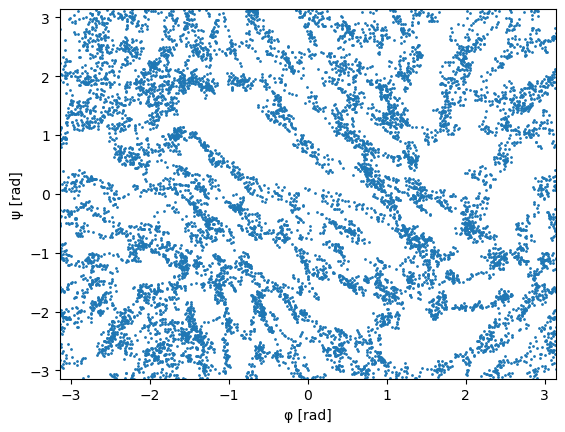

In [82]:
cvs_mtd_nn = monitor_cvs_mtd_nn.get_values()

plt.scatter(cvs_mtd_nn[:, 0], cvs_mtd_nn[:, 1], s=1)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel('φ [rad]')
plt.ylabel('ψ [rad]')
;

#### Create a class for [instantaneous collective force](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.6b00553)

In principle, the bias potential of metadynamics could be used as an estimate of the potential of mean force ("free energy") surface:

$$
A_{\mathrm{u}}(\xi) = -V_{\mathrm{bias}}^{\mathrm{MTD}}\left(\xi(\mathbf{q}), T\right) = -\sum \limits_{t' \le T} h(t') \exp \left(-\frac{1}{2} \sum \limits_{k}^{D} \frac{\left(\xi^{(k)}(\mathbf{q}) - \xi^{(k)}(t'_{i})\right)^{2}}{w_{k}^{2}} \right)
$$

However, a more accurate estimate can be obtained by using the *instantaneous collective forces* (ICFs), $\mathbf{f}$. ICFs can be computed and collected from adirectly from atomic positions and (unbiased) forces during a (potentially biased) MD simulation:

$$
\mathbf{f}(\mathbf{q}) = -(\mathbf{G}^{-1}_{W}\mathbf{W}) \cdot \nabla_{\mathbf{q}}V(\mathbf{q}) + \beta^{-1}\nabla_{\mathbf{q}}(\mathbf{G}^{-1}_{W}\mathbf{W})
$$

where $\mathbf{G}^{-1}_{W} \in \mathbb{R}^{D \times D}$ is the generalozed Gram matrix: $\mathbf{G}_{W} = \mathbf{W} \nabla_{\mathbf{q}}\xi$ with the transpose of the Jacobian matrix of the collective variables $\nabla_{\mathbf{q}}\xi$ and $\mathbf{W} \in \mathbb{R}^{D \times 3N}$ is an arbitrary vector field with the restriction that $\mathbf{G}_{W}$ must be invertible. A specific choice we use is $\mathbf{W} = \nabla_{\mathbf{q}}\xi$. 

As it can be shown, the expected value of the ICFs at a specific value of the collective variables sampled from a biased simulation is equal to the unbiased negative derivatives of the free energy with respect to the collective variables:

$$
\langle \mathbf{f}(\mathbf{q}) \rangle_{\xi = \xi^{*}, \mathrm{b}} = \langle \mathbf{f}(\mathbf{q}) \rangle_{\xi = \xi^{*}, \mathrm{u}} = -\nabla_{\xi} A_{\mathrm{u}}(\xi^{*})
$$

Since ICFs are rather noisy observations, we use the Gaussian process regression to reconstruct the free energy surface from these gradient-based observations.

In [83]:
class ICF:
    def __init__(self, cvs, calc, T, dtype=torch.float64):
        if cvs is None:
            raise ValueError("cvs list must be defined!")
        elif type(cvs) is not list:
            raise ValueError("cvs must be a list!")
        else:
            self.cvs = cvs
            self.dim = len(cvs)
        
        self.calc = calc
        self.T = torch.tensor(units.kB * T)
        self.dtype = dtype
        
    def get_positions(self, traj):
        return [atoms.get_positions() for atoms in traj]
    
    def get_forces(self, traj):
        return [self.calc.get_forces(atoms) for atoms in traj]
        
    def calculate(self, traj):
        q = torch.tensor(self.get_positions(traj), dtype=self.dtype)
        f = torch.tensor(self.get_forces(traj), dtype=self.dtype).flatten(start_dim=1, end_dim=2)
        N = f.shape[1]
        M = self.dim
        
        v = torch.stack([ft.vmap(cv)(q) for cv in self.cvs])
        g = torch.stack([ft.vmap(ft.jacrev(cv))(q) for cv in self.cvs]).flatten(start_dim=2, end_dim=3).permute(1, 2, 0)
        H = torch.stack([ft.vmap(ft.hessian(cv))(q).reshape(-1, N, N) for cv in self.cvs]).permute(1, 0, 2, 3)
        Hg = torch.einsum('bhij,bjg->bhgi', H, g)
        
        W = g.transpose(1, 2)
        DivW = torch.stack([ft.vmap(torch.trace)(H[:, m, :, :]) for m in range(M)]).permute(1, 0)
        Gw = torch.matmul(W, g)
        InvGw = torch.linalg.inv(Gw)
        GradGw = Hg + Hg.transpose(1, 2)
        GradInvGw = -torch.einsum('bij,bjkx,bkl->bilx', InvGw, GradGw, InvGw)
        term1 = torch.einsum('bij,bjx,bx->bi', InvGw, W, f) 
        term2 = torch.einsum('bijx,bjx->bi', GradInvGw, W) + torch.einsum('bij,bj->bi', InvGw, DivW)
        icf = term1 + 300 * units.kB * term2
        return [v.detach().numpy().T, icf.detach().numpy()]

#### Set up an ICF object

In [84]:
icf = ICF(cvs, calc_nn, 300)

#### Compute CV values and their ICF

In [85]:
mtd_nn_traj = Trajectory("mtd_nn.traj")

values, forces = icf.calculate(mtd_nn_traj)
values = torch.tensor(values)
forces = torch.tensor(forces)

#### Compute the free energy surface by fitting the ICFs by GPR using periodic squared exponential kernel

In [86]:
g = torch.linspace(-torch.pi, torch.pi, steps=48, dtype=dt)
grid_phi, grid_psi = torch.meshgrid(g, g, indexing="ij")
grid = torch.stack([grid_phi.flatten(), grid_psi.flatten()]).T.reshape(-1, 1, 2)

kernel_icf = PSEKernel()

gpr_icf = DTCGPR(kernel_icf, grid, values.reshape(-1, 1, 2), trainig_type="force", f_train=forces.reshape(-1, 1, 2))

delta = torch.tensor(4.0)
theta = torch.tensor(1.0)
periodicities = torch.tensor([2*torch.pi, 2*torch.pi], dtype=dt)
sigma_f = torch.tensor(10.0)
gpr_icf.set_parameters(delta, theta, periodicities, sigma=sigma_f)

In [87]:
free_energy = gpr_icf.predict_e(grid)
free_energy -= free_energy.min()

''

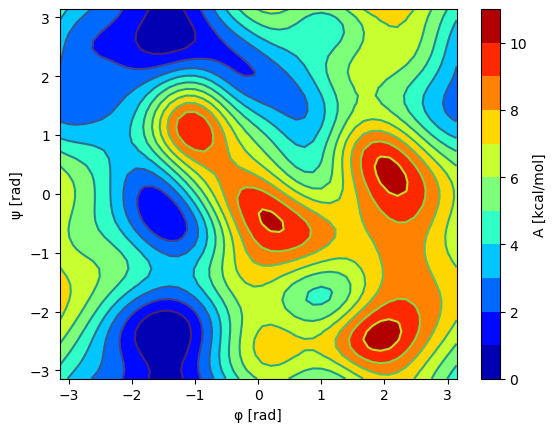

In [88]:
plt.contourf(grid_phi, grid_psi, free_energy.reshape(48, 48) * units.mol/units.kcal, cmap="jet", levels=12)
plt.colorbar(label='A [kcal/mol]')
plt.contour(grid_phi, grid_psi, free_energy.reshape(48, 48) * units.mol/units.kcal, levels=12)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel('φ [rad]')
plt.ylabel('ψ [rad]')
;